## Treinamento do modelo

Esse notebook está responsável por validar o modelo com os dados não utilizados para o treinamento. Por padrão, esse notebook utiliza todos os dados não treinados para fazer a validação, mas o período pode ser escolhido alterando as variáveis "data_minima" e "data_maxima".

Todo o processo de armazenamento, limpeza e preparo dos dados segue o mesmo processo dos notebooks anteriores, entretanto, para manter a organização dos códigos, essas funções foram armazenadas no arquivo **funcoes.py**.

---


In [1]:
# importação dos pacotes
import funcoes as fc

import os
import pandas as pd
import numpy as np

import datetime
import holidays

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# armazenamento das variáveis de ambiente
load_dotenv()

USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
DATABASE = os.getenv("DATABASE")
PORT = os.getenv("PORT")

In [3]:
# configurações das variáveis
data_minima = "2024-09-08"
data_maxima = "2024-10-08"

arquivo_bruto = "arquivo_bruto_validacao.csv"
arquivo_limpo = "arquivo_limpo_validacao.csv"
arquivo_tratado = "arquivo_tratado_validacao.csv"
arquivo_modelo = "xgb_model.json"

In [4]:
# armazenamento dos dados do banco de dados
fc.baixar_arquivo(
    user = USER,
    password = PASSWORD,
    host = HOST,
    database = DATABASE,
    port = PORT,
    data_minima = data_minima,
    data_maxima = data_maxima,
    arquivo_bruto = arquivo_bruto
)

Arquivo gerado: arquivo_bruto_validacao.csv


In [5]:
# limpeza dos dados
fc.limpar_dados(arquivo_bruto, arquivo_limpo)

Arquivo gerado: arquivo_limpo_validacao.csv


In [6]:
# extração das características e preparo dos dados
fc.extracao_de_caracteristicas(arquivo_limpo, arquivo_tratado)

Arquivo gerado: arquivo_tratado_validacao.csv


In [7]:
# carregamento dos dados e do modelo em memória
pasta_atual = os.getcwd()
pasta_pai = os.path.dirname(pasta_atual)
pasta_data = os.path.join(pasta_pai, "data")
pasta_models = os.path.join(pasta_pai, "models")
pasta_reports = os.path.join(pasta_pai, "reports")

df = pd.read_csv(f"{pasta_data}\\{arquivo_tratado}", parse_dates=["date"])\
    .sort_values(by=["date", "appId"])\
    .reset_index(drop=True)

model = xgb.XGBRegressor()
model.load_model(f"{pasta_models}\\{arquivo_modelo}")

In [8]:
# realizar a predição do modelo
colunas_X = [col for col in df.columns if col not in ["appId", "date", "proximo_dauReal"]]
colunas_y = "proximo_dauReal"

X = df[colunas_X]
y = df[colunas_y]

y_pred = model.predict(X)

msle  = mean_squared_log_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
mae  = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MSLE: {msle :.4f}")
print(f"MAPE: {mape :.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}\n")

MSLE: 0.1155
MAPE: 0.1537
MAE: 53698.7509
R2: 0.9480



In [ ]:
# Podemos observar que ocorreu uma leve perda de performance em relação as métricas MSLE, MAPE e R2,
# entretanto, ocorreu um aumento significativo do MAE. Apesar de ser normal ter uma performance de
# validação inferior a performance de treino, não esperavamos ter o dobro de MAE. Como podemos ver
# na tabela seguir, temos uma grande variação dos dados de "dauReal", o que pode explicar esse aumento
# do erro bruto. Entretanto, como próximo passo, seria interessante fazer essa investigação.

In [14]:
y.describe()

count    5.481000e+03
mean     3.777666e+05
std      1.133280e+06
min      7.510000e+02
25%      9.653625e+03
50%      3.657000e+04
75%      1.985824e+05
max      9.932455e+06
Name: proximo_dauReal, dtype: float64

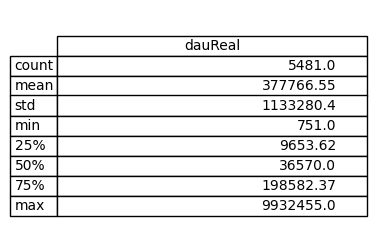

In [9]:
desc = y.describe().round(2)
desc_df = pd.DataFrame(desc, columns=[y.name])
desc_df.columns = ["dauReal"]

fig, ax = plt.subplots(figsize=(4, 3))
ax.axis('off')  # Hide axes
table = ax.table(cellText=desc_df.values,
                 colLabels=desc_df.columns,
                 rowLabels=desc_df.index,
                 loc='center')

table.scale(1, 1.2)

# Save to PNG
plt.savefig(f"{pasta_reports}\\tabela_dauReal_validacao.png")
plt.show()

In [ ]:
# Como comentado anteriormente, existe uma grande variação entre o valor mínimo e máximo, o que dificulta o treinamento do
# modelo. Uma forma para tentar contornar isso, é fazer o treinamento de diferentes modelos para cada aplicativo, uma vez
# que não esperamos ter uma variação tão grande de acessos quando comparando um aplicativo por vez. Esse processo não é
# complicado, e eu tenho um exemplo pronto desse tipo de abordagem em:
# https://www.kaggle.com/code/lucasbenazzicestari/store-sales-time-series-prediction

In [10]:
# devido a essa grande variação, os gráficos a seguir srão feitos medindo o resíduo percentual, ao invés do resíduo bruto.
residuos = ((y - y_pred) / y) * 100

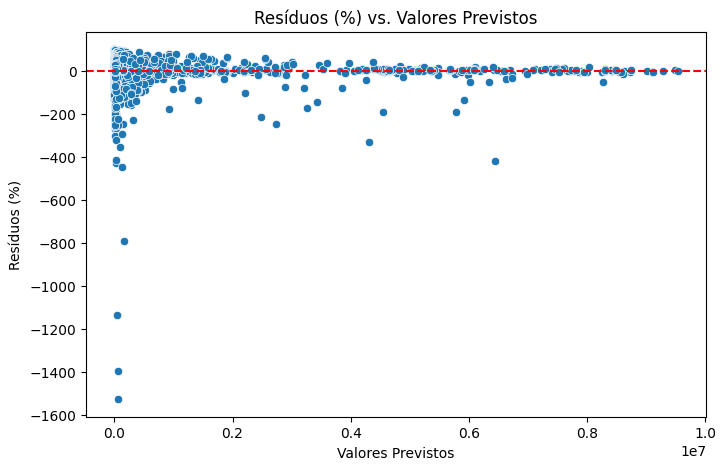

In [11]:
# Gráfico de resíduos vs previsão
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos (%)")
plt.title("Resíduos (%) vs. Valores Previstos")
plt.savefig(f"{pasta_reports}\\residuos_x_valores_previstos.png")
plt.show()

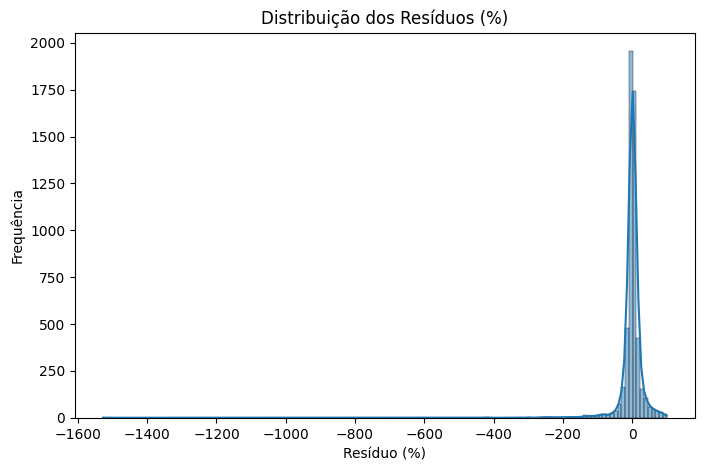

In [12]:
# Histograma dos resíduos
plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos (%)")
plt.xlabel("Resíduo (%)")
plt.ylabel("Frequência")
plt.savefig(f"{pasta_reports}\\distribuicao_residuos.png")
plt.show()

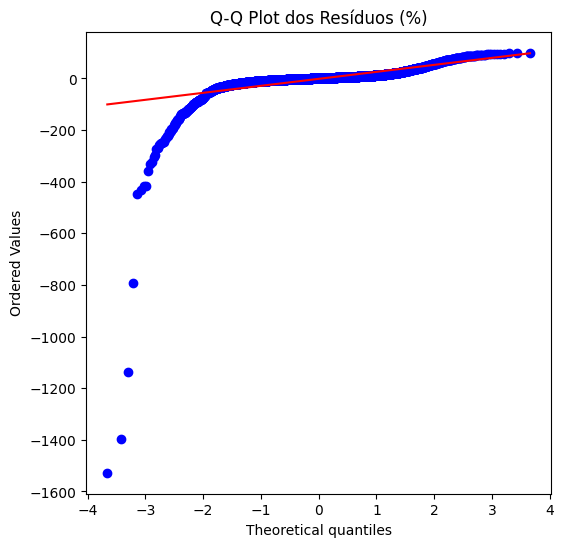

In [13]:
# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q Plot dos Resíduos (%)")
plt.savefig(f"{pasta_reports}\\q_q_plot.png")
plt.show()

In [ ]:
# Os comentários dos resultados resultados, e próximos passos, estão descritos no arquivo README.md.